In [1]:
import skimage
import numpy as np
from tifffile import TiffFile, imwrite
import matplotlib.pyplot as plt
import h5py

In [2]:
im = None

with TiffFile('data/1_01_R3D_D3D_3D_MERGED.tif') as tif:
    im = tif.series[0].levels[0].asarray()
    print(im.shape)

(100, 28, 1024, 1024)


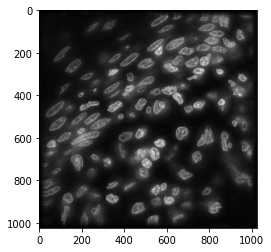

In [4]:
plt.imshow(im[0][50], cmap='gray')
im = im[0][50]

In [5]:
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

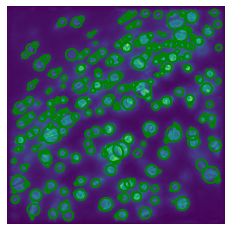

In [6]:
blobs_log = blob_log(im, min_sigma=1, max_sigma=30, num_sigma=200, threshold=.005, exclude_border=True)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig,ax = plt.subplots(1)
ax.imshow(im)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="green", linewidth=2, fill=False)
    ax.add_patch(c)
ax.set_axis_off()
plt.show()

In [7]:
image = im
cells = image > filters.threshold_otsu(image)
labeled_cells = measure.label(cells)

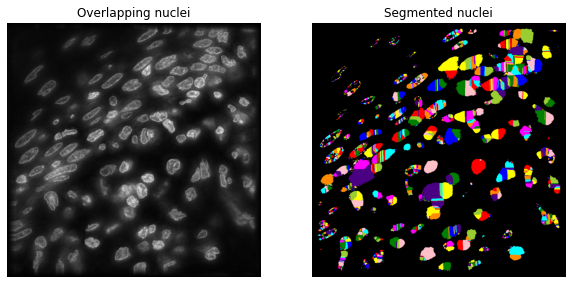

In [8]:
distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=1)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].axis('off')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
ax[1].axis('off')
plt.show()

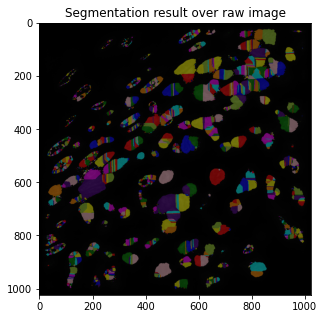

In [9]:
color_labels = color.label2rgb(segmented_cells, image, alpha=0.4, bg_label=0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(color_labels)
ax.set_title('Segmentation result over raw image')
plt.show()

In [10]:
with h5py.File('data/segmented_cells.h5', 'w') as hf:
    hf.create_dataset('segmented_cells', data=image)

In [1]:
import numpy as np
from tifffile import TiffFile, imwrite
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage as ndi


with h5py.File('../../data/centers.h5', 'r') as hf:

    centers = hf['exported_data'][:].squeeze()

In [6]:
with h5py.File('../../data/cube_all.h5', 'r') as hf:
    print(hf['image'].keys())

<KeysViewHDF5 ['CD163', 'CD3D', 'CD4', 'CD40L', 'CD68', 'CD8A', 'DNA1', 'DNA2', 'DNA3', 'DNA4', 'DNA5', 'DNA6', 'DNA7', 'GZMB', 'HLAA', 'HLADPB1', 'ICOS', 'LAG3', 'LAMP1_CD107A', 'PD1', 'PD1_2', 'PDL1', 'PDL1_2', 'SOX10', 'SQSTM', 'TIM3', 'TLR3', 'VIN', 'centers']>


In [1]:
import h5py
with h5py.File('../../data/cube.h5', 'a') as hf:
    old_edges = hf['edges'][:]
    old_vertices = hf['vertices'][:]
    
    del hf['edges']
    del hf['vertices']
    
    hf.create_dataset('edges', data=old_edges, chunks=True, maxshape=(None, 2))
    hf.create_dataset('vertices', data=old_vertices, chunks=True, maxshape=(None, 3))


In [4]:
from scipy.stats import wasserstein_distance
import numpy as np

a = np.array([1, 2, 3, 4, 5])
b = np.array([1, 2, 5])

wasserstein_distance(a, b)

0.6

In [3]:
import h5py
import numpy as np


with h5py.File('../../data/cube_all.h5', 'a') as hf:
    vertices = hf['vertices'][:]
    cell_types = hf.create_dataset('cell_types', data=np.random.randint(0, 3, size=len(vertices)), chunks=True, maxshape=(None,))

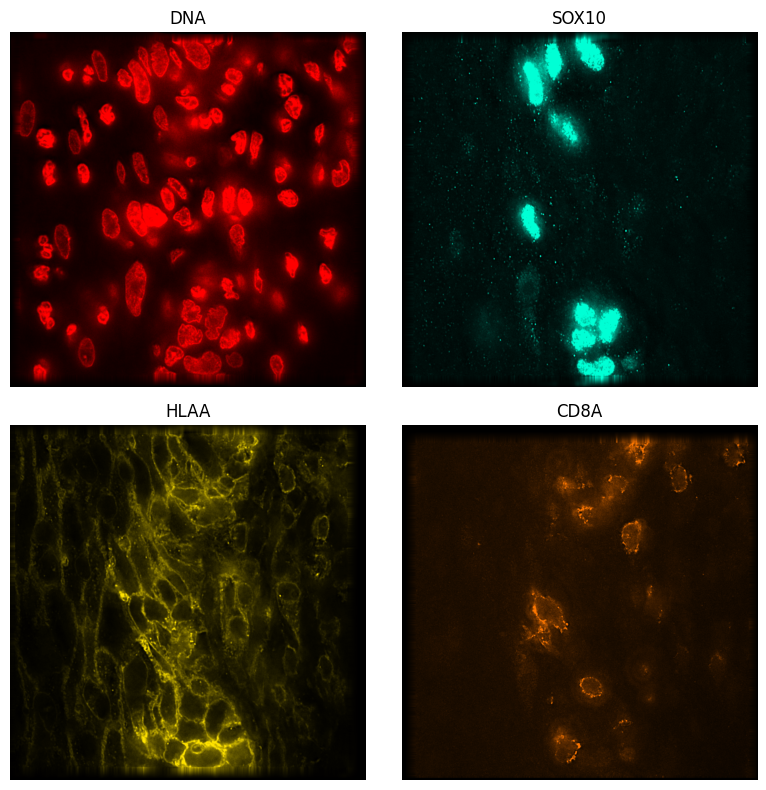

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

channels = ['CD163', 'CD3D', 'CD4', 'CD40L', 'CD68', 'CD8A', 'DNA1', 'DNA2', 'DNA3', 'DNA4', 'DNA5', 
            'DNA6', 'DNA7', 'GZMB', 'HLAA', 'HLADPB1', 'ICOS', 'LAG3', 'LAMP1_CD107A', 'PD1', 'PD1_2', 
            'PDL1', 'PDL1_2', 'SOX10', 'SQSTM', 'TIM3', 'TLR3', 'VIN', 'centers']


def create_colormap(color_hex, name):
    color_rgb = [int(color_hex[i:i+2], 16) / 255.0 for i in (1, 3, 5)]
    cmap_data = {
        'red': [(0.0, 0.0, 0.0), (1.0, color_rgb[0], color_rgb[0])],
        'green': [(0.0, 0.0, 0.0), (1.0, color_rgb[1], color_rgb[1])],
        'blue': [(0.0, 0.0, 0.0), (1.0, color_rgb[2], color_rgb[2])]
    }
    return LinearSegmentedColormap(name, cmap_data)

hex_colors = ['#ff0000', '#00ffd5', '#ffe300', '#FD7702']
color_names = ['color1', 'color2', 'color3', 'red']
colormaps = [create_colormap(color, name) for color, name in zip(hex_colors, color_names)]


with h5py.File('../../data/cube_all.h5', 'r') as hf:
    cube = hf['image']
    
    cd4 = cube['CD8A'][:]*255
    dna = cube['DNA1'][:]*255
    sox10 = cube['SOX10'][:]*255
    tim3 = cube['HLAA'][:]*255
    
    v = 150
    dna = np.where((255 - dna) < v,255,dna+v)
    v = 240
    sox10 = np.where((255 - sox10) < v,255,sox10+v)
    v = 210
    tim3 = np.where((255 - tim3) < v,255,tim3+v)
    v = 235
    cd4 = np.where((255 - cd4) < v,255,cd4+v)
    

    
    
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Subplot (0, 0)
im1 = axes[0, 0].imshow(dna[30, :, :], cmap=colormaps[0])
axes[0, 0].set_title('DNA')
axes[0, 0].axis('off')

# Subplot (0, 1)
im2 = axes[0, 1].imshow(sox10[30, :, :], cmap=colormaps[1])
axes[0, 1].set_title('SOX10')
axes[0, 1].axis('off')

# Subplot (1, 0)
im3 = axes[1, 0].imshow(tim3[30, :, :], cmap=colormaps[2])
axes[1, 0].set_title('HLAA')
axes[1, 0].axis('off')

# Subplot (1, 1)
im4 = axes[1, 1].imshow(cd4[30, :, :], cmap=colormaps[3])
axes[1, 1].set_title('CD8A')
axes[1, 1].axis('off')

fig.tight_layout()
plt.show()

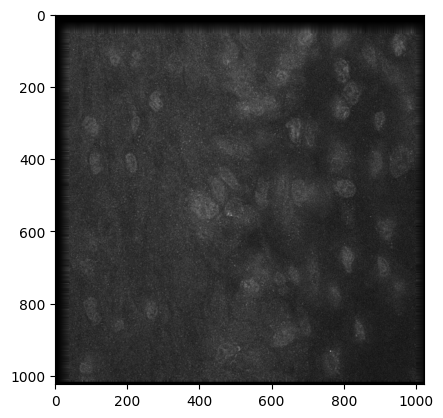

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

channels = ['CD163', 'CD3D', 'CD4', 'CD40L', 'CD68', 'CD8A', 'DNA1', 'DNA2', 'DNA3', 'DNA4', 'DNA5', 
            'DNA6', 'DNA7', 'GZMB', 'HLAA', 'HLADPB1', 'ICOS', 'LAG3', 'LAMP1_CD107A', 'PD1', 'PD1_2', 
            'PDL1', 'PDL1_2', 'SOX10', 'SQSTM', 'TIM3', 'TLR3', 'VIN', 'centers']

with h5py.File('../../data/cube_all.h5', 'r') as hf:
    cube = hf['image']
    
    cd4 = cube['CD8'][:]
    dna = cube['DNA1'][:]
    sox10 = cube['SOX10'][:]
    tim3 = cube['HLAA'][:]
    
    c = 4


    plt.imshow(cube[channels[c]][30 , :, :], cmap='gray')       

In [19]:
import h5py
import numpy as np


with h5py.File('../../data/cube_all.h5', 'a') as hf:
    edges = np.array(hf['edges'][:]).tolist()
    edges.append([55, 43])
    del hf['edges']
    hf.create_dataset('edges', data=edges, chunks=True, maxshape=(None, 2))

In [14]:
import h5py
import numpy as np


with h5py.File('../../data/cube_all.h5', 'a') as hf:
    print(hf['vertices'][:].shape)

(89, 3)


In [17]:
with h5py.File('../../data/cube_all.h5', 'a') as hf:
    print(hf['edges'][:][83])

[42 55]


In [18]:
with h5py.File('../../data/cube_all.h5', 'a') as hf:
    print(hf['edges'][:][82])

[42 43]


In [1]:
import h5py

with h5py.File('../../data/cube_all.h5', 'r') as hf:
    print(hf['image']['CD8A'][:].shape)

(55, 1024, 1024)
